In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr


In [2]:
# Set up files
mydir = 'data/ordinaryFiveBlocksData'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]

numSubj = len(files)
print('Number of subjects: ', numSubj)

Number of subjects:  12


In [3]:
# Initialize variables
numRepeats = 10 # 10 passages
block_start = 2
block_end = block_start + numRepeats - 1   # the last block
numQPerPsg = 5

subj_include = [None] * numSubj
subj_readingSpeed = [None] * numSubj
subj_thresholds = np.full((numSubj, numRepeats), np.nan)

print('Shape thresholds matrix:', subj_thresholds.shape)

Shape thresholds matrix: (12, 10)


In [4]:
for subj in range(numSubj):
    mainOutput = pd.read_csv(os.path.join(mydir, files[subj]))

    psg_resp = np.full((numRepeats, numQPerPsg), np.nan)

    # Check if the participant got at least 50% accuracy
    for psg in range(2, 12):
        questionBlock = psg * 2

        labelName_question = f"{questionBlock}_1"
        questionBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_question].iloc[:numQPerPsg]

        psg_resp[psg - 2, :] = (
            questionBlock_cond['questionAndAnswerCorrectAnswer'] ==
            questionBlock_cond['questionAndAnswerResponse']
        ).values

    psg_percentCorrect = np.nanmean(psg_resp, axis=1)
    assert psg_percentCorrect.shape == (numRepeats,)

    # Whether we should include this passage
    psg_include = np.where(psg_percentCorrect >= 0.6)[0]


    # Calculate reading speed
    psg_wordsPerMin = np.full(numRepeats, np.nan)
    for psg in range(2, 12):
        readingBlock = psg * 2 - 1

        labelName_reading = f"{readingBlock}_1"
        readingBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_reading].iloc[1:3]
        numWords = readingBlock_cond['readingPageWords']
        reading_time = readingBlock_cond['readingPageDurationOnsetToOffsetSec']
        pg_wordsPerMin = numWords / (reading_time / 60)
        psg_wordsPerMin[psg - 2] = np.nanmean(pg_wordsPerMin)

    subj_include[subj] = psg_include
    psg_wordsPerMin[np.where(psg_percentCorrect < 0.6)] = np.nan
    subj_readingSpeed[subj] = psg_wordsPerMin[psg_include]
    subj_thresholds[subj, psg_include] = psg_wordsPerMin[psg_include]


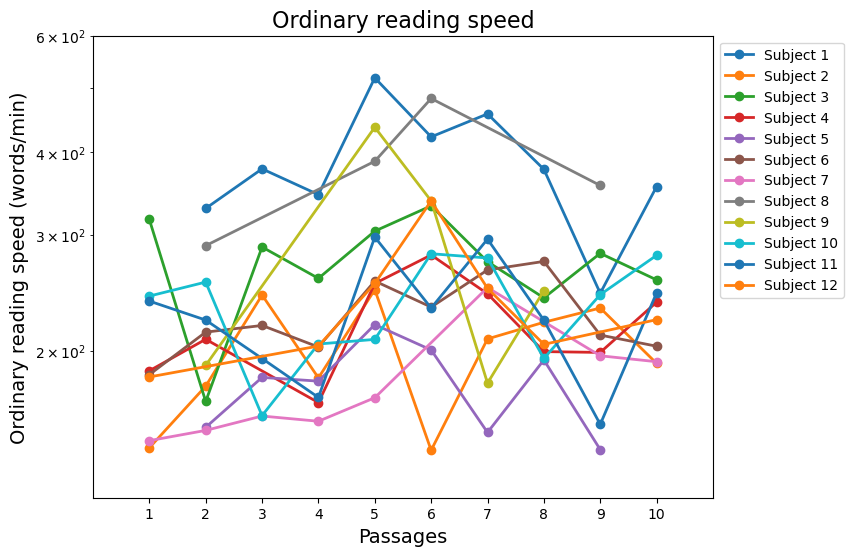

In [6]:
# Plot reading speed
# passage 0 was excluded as practice
cmap = plt.cm.jet(np.linspace(0, 0.8, numSubj))

plt.figure(figsize = (8, 6))
for subj in range(numSubj):
    plt.plot(subj_include[subj]+1, subj_readingSpeed[subj], 'o-', linewidth=2, #color=cmap[subj],
        label=f'Subject {subj + 1}'
    )
plt.xlim([0, 11])
plt.xticks(range(1, 11))
plt.ylim([120, 600])
plt.title('Ordinary reading speed', fontsize = 16)
plt.xlabel('Passages', fontsize = 14)
plt.ylabel('Ordinary reading speed (words/min)', fontsize = 14)
plt.yscale('log')
plt.yticks(size = 14)
plt.yticks(size = 14)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


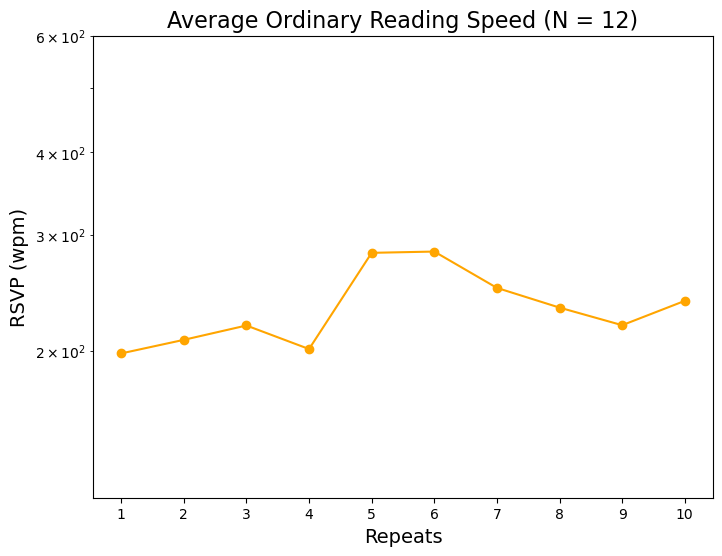

In [21]:
mean_log_thresholds = np.nanmean(np.log10(subj_thresholds), axis=0)

plt.figure(figsize=(8, 6))
# patch_min = 600 - 200
# patch_max = 600 + 200
# plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
plt.plot(range(1,11), 10 ** mean_log_thresholds, marker='o', color = 'orange')
plt.title(f'Average Ordinary Reading Speed (N = {numSubj})', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks(range(1,11))
plt.ylabel('RSVP (wpm)', fontsize = 14)
plt.yscale('log')
plt.ylim([120, 600])
# plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()

In [7]:
def plot_test_retest_scatter(data, group_X, group_Y):
    '''
    This function filters the data given the provided groupings and plots a scatter plot of test vs. retest
    It can give us an intuition of the within- and between- individual variances
    (i.e., if the within-std is large relative to the btw-std, R is low, and vice versa)
    
    Inputs:
    subj_data:        thresholds for each repeat of each individual. 
                      2D matrix with rows as individuals and columns as repeats.
    group_X, group_Y: specify which repeat(s) (i.e., columns) to include when averaging and plotting
                      for each dimension (X and Y).
                      These two arrays are lists but not np arrays.
    '''
    
    # filter data given the provided groupings
    group_X_array = np.array(group_X)
    group_Y_array = np.array(group_Y)

    data_X = data[:, group_X_array - 1]
    data_Y = data[:, group_Y_array - 1]
    
    
    # calculate one mean for each subject
    means_X = np.nanmean(data_X, axis = 1)
    means_Y = np.nanmean(data_Y, axis = 1)
    
    r_value, _ = pearsonr(means_X, means_Y)
    

    # Create scatter plot
    plt.figure(figsize=(4, 4))  # Make the plot square
    plt.scatter(10 ** means_X, 10 ** means_Y, color='purple', alpha = 0.7)
    plt.plot([100, 500], [100, 500], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')

    # add ticks and format them as normal floats
    tick_positions = np.linspace(100, 500, num=5)  
    plt.xticks(tick_positions, labels=[f"{x:.0f}" for x in tick_positions], fontsize = 12)
    plt.yticks(tick_positions, labels=[f"{x:.0f}" for x in tick_positions], fontsize = 12)

    # Add labels and legend
    plt.xlabel(f'Average over repeats {group_X}', fontsize = 12)
    plt.ylabel(f'Average over repeats {group_Y}', fontsize = 12)
    plt.title(f'Test vs. Retest Correlation (R = {round(r_value,2)})', fontsize = 16)

    # Show the plot
    plt.show()


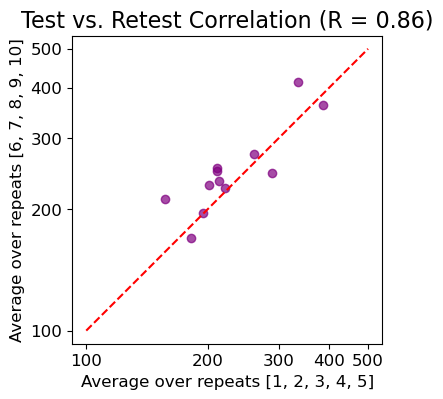

In [8]:
plot_test_retest_scatter(np.log10(subj_thresholds), [1, 2, 3, 4, 5], [6, 7, 8, 9, 10])
